# Extract curves into striplogs

Sometimes you'd like to summarize or otherwise extract curve data (e.g. wireline log data) into a striplog (e.g. one that represents formations).

We'll start by making some fake CSV text — we'll make 5 formations called A, B, C, D and E:

In [1]:
data = """Comp Formation,Depth
A,100
B,200
C,250
D,400
E,600"""

If you have a CSV file, you can do:

    s = Striplog.from_csv(filename=filename)
    
But we have text, so we do something slightly different, passing the `text` argument instead. We also pass a `stop` argument to tell Striplog to make the last unit (E) 50 m thick. (If you don't do this, it will be 1 m thick).

In [2]:
from striplog import Striplog

s = Striplog.from_csv(text=data, stop=650)

/home/matt/miniconda3/envs/welly/lib/python3.9/site-packages/striplog/striplog.py:512: UserWarning: No lexicon provided, using the default.
  warnings.warn(w)


Each element of the striplog is an `Interval` object, which has a top, base and one or more `Component`s, which represent whatever is in the interval (maybe a rock type, or in this case a formation). There is also a `data` field, which we will use later.

In [3]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 200.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'formation': 'A'})]})

We can plot the striplog. By default, it will use a random legend for the colours:

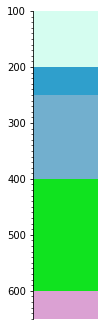

In [4]:
s.plot(aspect=3)

Or we can plot in the 'tops' style:

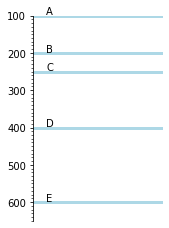

In [5]:
s.plot(style='tops', field='formation', aspect=1)

## Random curve data

Make some fake data:

In [6]:
from welly import Curve
import numpy as np

depth = np.linspace(0, 699, 700)
data = np.sin(depth/10)
curve = Curve(data=data, index=depth)

Plot it:

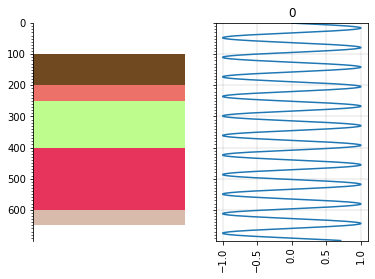

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, sharey=True)

axs[0] = s.plot(ax=axs[0])
axs[1] = curve.plot(ax=axs[1])

## Extract data from the curve into the striplog

In [8]:
s = s.extract(curve.values, basis=depth, name='GR')

Now we have some the GR data from each unit stored in that unit:

In [9]:
s[1]

Interval({'top': Position({'middle': 200.0, 'units': 'm'}), 'base': Position({'middle': 250.0, 'units': 'm'}), 'description': '', 'data': {'GR': array([ 0.94912455,  0.97582052,  0.99276641,  0.9997929 ,  0.99682979,
        0.98390669,  0.96115272,  0.92879523,  0.88715753,  0.83665564,
        0.77779416,  0.71116122,  0.6374226 ,  0.55731505,  0.471639  ,
        0.38125049,  0.28705265,  0.18998668,  0.09102242, -0.00885131,
       -0.1086366 , -0.20733642, -0.30396461, -0.39755568, -0.48717451,
       -0.57192566, -0.65096231, -0.72349476, -0.78879829, -0.8462204 ,
       -0.89518737, -0.93520992, -0.96588815, -0.98691556, -0.99808203,
       -0.99927599, -0.99048552, -0.97179845, -0.94340148, -0.90557836,
       -0.858707  , -0.80325573, -0.73977859, -0.66890982, -0.59135753,
       -0.50789659, -0.41936092, -0.32663513, -0.23064571, -0.13235175])}, 'components': [Component({'formation': 'B'})]})

So we could plot a segment of curve, say:

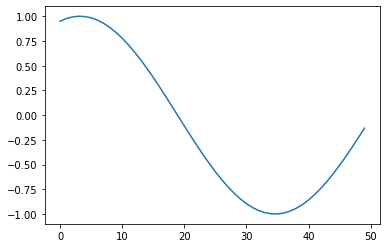

In [10]:
plt.plot(s[1].data['GR'])

## Extract and reduce data

We don't have to store all the data points. We can optionaly pass a function to produce anything we like, and store the result of that:

In [11]:
s = s.extract(curve, basis=depth, name='GRmean', function=np.nanmean)

s[1]

Interval({'top': Position({'middle': 200.0, 'units': 'm'}), 'base': Position({'middle': 250.0, 'units': 'm'}), 'description': '', 'data': {'GR': array([ 0.94912455,  0.97582052,  0.99276641,  0.9997929 ,  0.99682979,
        0.98390669,  0.96115272,  0.92879523,  0.88715753,  0.83665564,
        0.77779416,  0.71116122,  0.6374226 ,  0.55731505,  0.471639  ,
        0.38125049,  0.28705265,  0.18998668,  0.09102242, -0.00885131,
       -0.1086366 , -0.20733642, -0.30396461, -0.39755568, -0.48717451,
       -0.57192566, -0.65096231, -0.72349476, -0.78879829, -0.8462204 ,
       -0.89518737, -0.93520992, -0.96588815, -0.98691556, -0.99808203,
       -0.99927599, -0.99048552, -0.97179845, -0.94340148, -0.90557836,
       -0.858707  , -0.80325573, -0.73977859, -0.66890982, -0.59135753,
       -0.50789659, -0.41936092, -0.32663513, -0.23064571, -0.13235175]), 'GRmean': -0.12697991702493913}, 'components': [Component({'formation': 'B'})]})

Other helpful reducing functions:

- `np.nanmedian` &mdash; median average (ignoring nans)
- `np.product` &mdash; product
- `np.nansum` &mdash; sum (ignoring nans)
- `np.nanmin` &mdash; minimum (ignoring nans)
- `np.nanmax` &mdash; maximum (ignoring nans)
- `scipy.stats.mstats.mode` &mdash; mode average
- `scipy.stats.mstats.hmean` &mdash; harmonic mean
- `scipy.stats.mstats.gmean` &mdash; geometric mean

Or you can write your own, for example:

    def trim_mean(a):
        """Compute trimmed mean, trimming min and max"""
        return (np.nansum(a) - np.nanmin(a) - np.nanmax(a)) / a.size
        
Then do:

    s.extract(curve, basis=basis, name='GRtrim', function=trim_mean)
    
The function doesn't have to return a single number like this, it could return anything you like, including a dictionary.

We can also add bits to the `data` dictionary manually:

In [12]:
s[1].data['foo'] = 'bar'
s[1]

Interval({'top': Position({'middle': 200.0, 'units': 'm'}), 'base': Position({'middle': 250.0, 'units': 'm'}), 'description': '', 'data': {'GR': array([ 0.94912455,  0.97582052,  0.99276641,  0.9997929 ,  0.99682979,
        0.98390669,  0.96115272,  0.92879523,  0.88715753,  0.83665564,
        0.77779416,  0.71116122,  0.6374226 ,  0.55731505,  0.471639  ,
        0.38125049,  0.28705265,  0.18998668,  0.09102242, -0.00885131,
       -0.1086366 , -0.20733642, -0.30396461, -0.39755568, -0.48717451,
       -0.57192566, -0.65096231, -0.72349476, -0.78879829, -0.8462204 ,
       -0.89518737, -0.93520992, -0.96588815, -0.98691556, -0.99808203,
       -0.99927599, -0.99048552, -0.97179845, -0.94340148, -0.90557836,
       -0.858707  , -0.80325573, -0.73977859, -0.66890982, -0.59135753,
       -0.50789659, -0.41936092, -0.32663513, -0.23064571, -0.13235175]), 'GRmean': -0.12697991702493913, 'foo': 'bar'}, 'components': [Component({'formation': 'B'})]})